# Rough Prototype Tight-Binding Hamiltonian Model Builder
S. Torrisi, E. Muramoto, T. Zhou, S. Fang


### First: import the right libraries, and specify lists/dictionaries that are going to be useful to the later operation of the program.

In [19]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.interpolate as interp

# Orbitals in the order of wannier90 output
bilayer_orbitals = [
          "d1b","d2b", "d3b", "d4b", "d5b", # Bottom transition metal D orbitals
          "d1t","d2t","d3t","d4t","d5t",    # Top transition metal D orbitals
          "pzbi","pybi","pxbi",           # Bottom Inner chalcogen P Orbitals
          "pzbo","pybo","pxbo",             # Bottom Outer chalcogen P Orbitals
          "pzto","pyto","pxto",             # Top outer Chalcogen P orbitals
          "pzti","pyti","pxti"              # Top inner Chalcogen P orbitals
]

# Dictionaries to be populated;
# Orb_to_index accepts the name of an orbital and returns an index.
# index_to_orb does the opposite.
orb_to_index = {}
index_to_orb = {}

for n in range(22):
    orb_to_index[bilayer_orbitals[n]] = n
    index_to_orb[n] = bilayer_orbitals[n]

In [20]:

class atom(object):
    """
    Contains three attributes:
    
    int layer : 0 or 1 depending on lower/upper
    tuple index (int,int) which specifies where it is on it's original undistorted bravais lattice
    tuple position (float,float) or (float,float,float) depending on if we have xy or xyz 
    """
    def __init__(self,layer=0,index=(0,0),position=(0,0)):
        self.layer=layer # takes form 0,1
        self.index=index # takes form (n,m) or 'None'
        self.position= position #takes form (x,y) or #(x,y,z)
        

        
def generate_atom_positions(A,R,N,M,z=3.5):
    """
    Generates a simple rotation with no relaxation and a constant z coordinate
    
    np array A : Matrix of 2D bravais lattice which goes [[a11, a21],[a12,a22]] acting on [n,m]
    np array R : Matrix which rotates the lattice
    int N:       Extent of one direction of the lattice
    int M:       Extent of another direction of the lattice
    """
    indices=[]
    positions=[]
    
    atoms=[]
    # Set up (n,m) integer tuples which index the atoms in each lattice
    for n in range(N):
        for m in range(M):
            indices.append((n,m))
            
    # Obtain positions by multiplying the indices by the Bravais matrix A
    for x in indices:
        # Generate bottom layer 'atom'
        newpos=np.append(np.dot(A,np.array(x)),(z))
        atoms.append(atom(layer=0,index=x,position=newpos))
        # Generate top layer 'atom'
        newpos=np.append(np.dot(np.dot(R,A),np.array(x)),z)
        atoms.append(atom(layer=1,index=x,position=newpos))
        
    
    # List of objects of type atom
    return atoms
        
    
def plot_atom_positions(atoms):

    bot_atoms=[at for at in atoms if at.layer==0]
    top_atoms=[at for at in atoms if at.layer==1]
    
    plt.figure()
    plt.scatter([at.position[0] for at in bot_atoms], [at.position[1] for at in bot_atoms],color='b',label='Bottom')
    plt.scatter([at.position[0] for at in top_atoms], [at.position[1] for at in top_atoms],color='r',label='Top')
    plt.legend()
    plt.show()
    
def read_positions(file):
    
    ## Assumes data which is formatted as 
    #  x,y,layer   | with type | float, float, 0 or 1
    # or 
    # x,y,z, layer | with type | float, float, float, 0 or 1
    #  for when we implement z-relaxation.
    
    
    with open(file,'r') as f:
        thelines=f.readlines()
        
    ####################
    # This chunk of code checks to see if there is a alphabet letter in the first line
    # which is a reasonable expectation for the header. If there is a header, it starts on the second line.
    ####################
    alphabet="abcdefhijklmnopqrstuvwxyz"
    alphabet=[alphabet[i] for i in range(26)]
    start_idex=0
    for letter in alphabet:
        if letter in thelines[0].lower():
            start_index=1
    
    ####################
    # Turn the lines into atoms
    ####################    
    
    atoms=[None]*len(thelines[start_index:])
    for n in range(len(thelines[start_index:])):
        [xpos, ypos, layer] = thelines.split(',')
        atoms[n] = atom(layer=int(layer), position=(float(xpos),float(ypos)))


    return atoms

def unit_cell_modulus(A,Dx,Dy,Ainv=None):
    """ 
        
        Assumes A has the form
        
        [a1x, a2x] [n] = [x]
        [a1y, a2y] [m] = [y]
        
        so takes the transpose to make it
        
        [A1x, A1y]
        [A2x, A2y]
                
        Takes an x,y position and modulates it into the unit cell.
        
        Works by solving the system of equations
        x = c * a1_x  + d a2_x
        y = c * a1_y  + d a2_y 
        
        Then taking the coefficients c and d modulo 1, which places them into the unit cell.
        
        If this will be called many times, pass the inverted matrix A in as Ainv.

    
    """
    if Ainv is None:
        Ainv = la.inv(A.T)
    indexes=np.dot(Ainv,np.array([Dx,Dy]))   # Obtain c and d   
    print(indexes)
    indexes=np.array([x%1 for x in indexes]) # Modulate by 1
    print(indexes)

    unit_cell_pos= np.dot(A.T,indexes)         # Put back into real space
    return unit_cell_pos[0],unit_cell_pos[1]

print(unit_cell_modulus(A,51,1))

[ 8.58324192  9.18674222]
[ 0.58324192  0.18674222]
(2.2098608015922947, -0.65699999999999759)


In [21]:
def query_tbh_data(Dx, Dy, orb_from, orb_to, Dz=0):
    
    ###############
    # This is where we would query the database, somehow, by passing it
    # the difference in position between the two orbitals as well as the layer of each atom.
    ###############
    
    
    
    
    pass

def pre_query_tbh_data(NN):

    """ Sketch function for pre-downloading and then computing the orbital strengths 
    
    """
    TBH_DATA=np.empty(shape=(20,20,20,22,22),dtype=float)
    
    for x in range(20):
        for y in range(20):
            for z in range(20):
                for k in range(22):
                    for l in range(22):
                        pass
                        #
                        #TBH_DATA[x,y,z,k,l]=
                    
                
    
    return TBH_DATA
    
def build_model(atoms,A):
    """ 
        variable : datatype, description 
        atoms: atom object, list of atoms
    """
    NN = len(atoms)
    
    TBH = np.empty(shape=(NN*11,NN*11))
    
    
    
    
    for i in len(atoms):
        for j in len(atoms):
            for k in range(11):
                for l in range(11):
                    Dx = atoms[j].position[0] - atoms[i].position[0]
                    Dy = atoms[j].position[1] - atoms[i].position[1]
                    Dx,Dy = unit_cell_modulus(A,Dx,Dy)

                    orb_from = index_to_orb(k)
                    orb_to   = index_to_orb(l)
                    TBH[i*11+k,j*11+l] = query_tbh_data(Dx,Dy,orb_from,orb_to)
    
    

def build_interp_object(orb_from,orb_to,fidelity=2, x_count=20,y_count=20,z_count=20):
    """
    Queries the database to assemble a multidimensional array of coupling strengths
        to turn into a scipy interpolation object. 
        
    NO STRAIN YET.
        
    str orb_from: which orbital we are considering from our 'home base' site
    str orb_to:   which orbital we are considering from our 'to' site
    fidelity: int 1, 2, 4, or 5, so long as it divides 20: the spacing of sampling to take
                    from the individual displacement runs (of which there are 400).
    x_count: how many x-values we had in our interpolation
    y_count: how many y-values we had in our interpolation
    z_count: how many z-values hwe had in our interpolation

    """
    
    X_extent = x_count / fidelity
    Y_extent = y_count / fidelity
    Z_extent = z_count / fidelity
    points=np.empty(shape=(X_extent,Y_extent,Z_extent))
    
    for i in X_extent:
        for j in Y_extent:
            for k in Z_extent:
                points[i,j,j]
    
    
                
            
    
    

## Set Up Physics Parameters

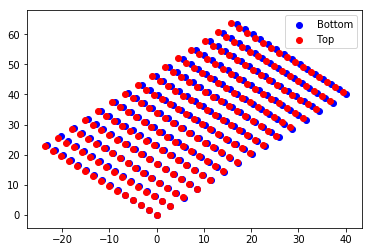

In [26]:
# Physics Parameters

a = 3.18 # Lattice constant of material (MoS2)
a= 3.314 # Lattice constant of material (TaS2)
# Bravais Lattice matrix which turns indices to real-space positions:
A = np.array([[1., np.cos(np.pi/3)  ],[0, np.sin(np.pi/3)]]  ) * a  #MoS2
A = np.array([[np.sqrt(3)/2, -.5],[np.sqrt(3)/2, .5]]) * a      #Ta S2
theta = 1.05 # Angle of rotation in degrees  
theta_r= theta* np.pi / (180.)   # Convert to radians
R = np.array([ [ np.cos(theta_r), - np.sin(theta_r)],[np.sin(theta_r), np.cos(theta_r)]]) # Rotation Matrix

NN = 12**2

plot_atom_positions(generate_atom_positions(A,R,15,15))

    









# Build Model TBH

In [23]:

# Where NN is the total number of atoms in the lattice 
TBH = np.empty(shape=(22*NN,22*NN))

for i in range(22*NN):
    for j in range(22*NN):
        
        

SyntaxError: unexpected EOF while parsing (<ipython-input-23-9bce0a2ad346>, line 8)